In [1]:
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import squarify
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#Term frequency vectorizer
from sklearn.model_selection import train_test_split
import re
import xgboost

### Initial Look:

In [2]:
train = pd.read_csv("train.tsv", sep='\t', header=0)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
test = pd.read_csv("test.tsv", sep='\t', header=0)
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [4]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [5]:
train.shape

(1482535, 8)

In [6]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

Before we move forward, since this is an exercise that will require text analysis, we will be converting the objects representing the categories into strings for easier manipulation of data.

In [7]:
non_text = [',','-','.','&','%','#', '(',')','[',']','*','!','✨','▪️','"','~',"'"]
for symbols in non_text: 
    train['category_name'] = train['category_name'].str.replace(symbols, '') 
    test['category_name'] = test['category_name'].str.replace(symbols, '') 
    train['item_description'] = train['item_description'].str.replace(symbols, '') 
    test['item_description'] = test['item_description'].str.replace(symbols, '') 
    train['name'] = train['name'].str.replace(symbols, '') 
    test['name'] = test['name'].str.replace(symbols, '') 
train.info() 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


## II. Categories

In [8]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/Tshirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers Tablets/Components Parts,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVAVIV Blouse,1,Women/Tops Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags Leather horses Retail for rm eac...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
train['category_name'].head()

0                                    Men/Tops/Tshirts
1    Electronics/Computers  Tablets/Components  Parts
2                          Women/Tops  Blouses/Blouse
3                  Home/Home Décor/Home Décor Accents
4                             Women/Jewelry/Necklaces
Name: category_name, dtype: object

In [10]:
print('unique categories: ', train['category_name'].nunique())
print('unique products: ', train['name'].nunique())

unique categories:  1287
unique products:  1214053


There are 1,287 unique categories and 1,225,273 products within those cateogires. These labels will be able to help determine what price each product will be. Let us look at some stats on these categories in more detail

In [11]:
print('Top Ten Categories:')
train['category_name'].value_counts()[:10]

Top Ten Categories:


Women/Athletic Apparel/Pants Tights Leggings                60177
Women/Tops  Blouses/TShirts                                 46380
Beauty/Makeup/Face                                          34335
Beauty/Makeup/Lips                                          29910
Electronics/Video Games  Consoles/Games                     26557
Beauty/Makeup/Eyes                                          25215
Electronics/Cell Phones  Accessories/Cases Covers  Skins    24676
Women/Underwear/Bras                                        21274
Women/Tops  Blouses/Tank Cami                               20284
Women/Tops  Blouses/Blouse                                  20284
Name: category_name, dtype: int64

Womens, Beauty, and Electronics come at the top ten frequency of products for raw categories. The dataset provide valuable information about the primary kinds of customer community that Mercari may most likely have. There is not gender designation or order details, but there seems to be a large frequency of Women's beauty products and clothing. Let us see the price breakdowns of products:

In [12]:
print('Train Price Description: \n',train.price.describe())

Train Price Description: 
 count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


Price seems to go from a minimum of 0, to a maximum of $2009 for the trainining set. As this is the target variable, we will be using this as our Y value. Let's expand more on the price distributions to see where the prices of products stand on the dataset:

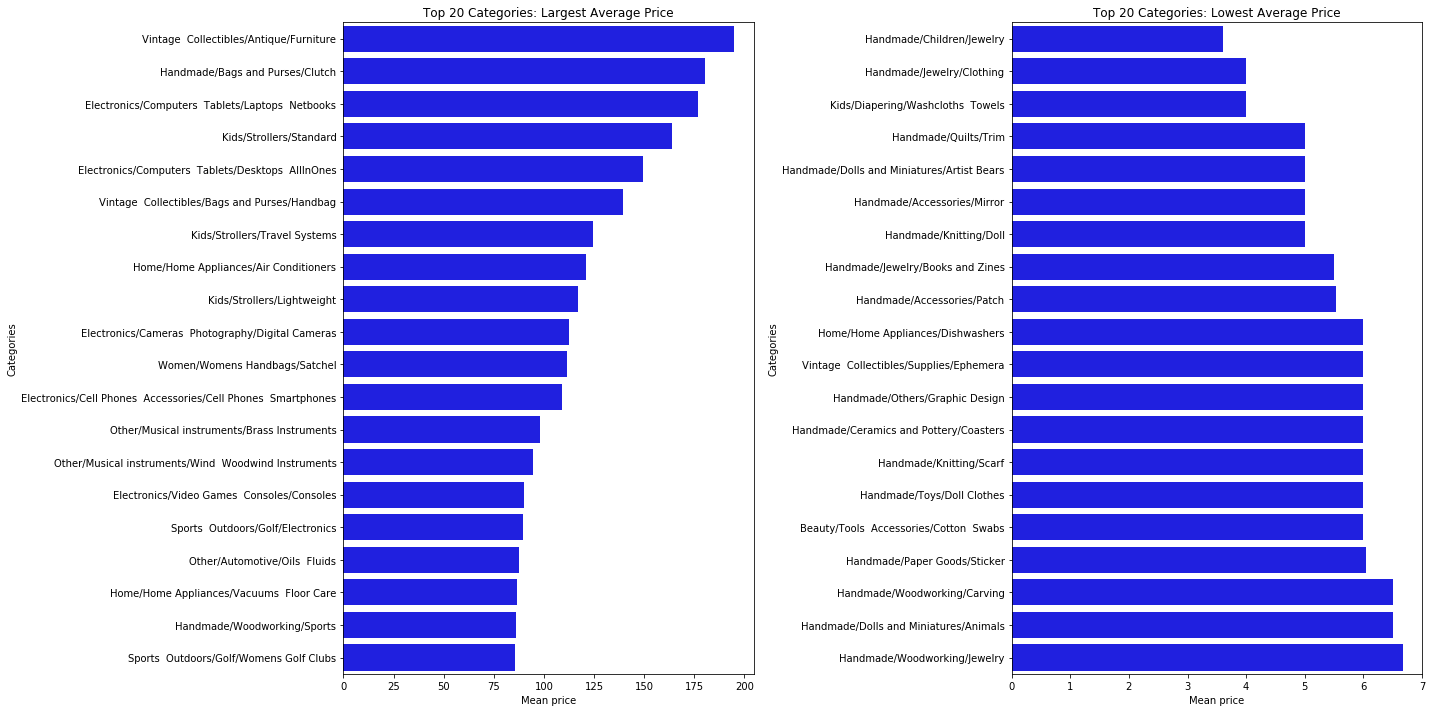

In [13]:
categories = train.groupby(train.category_name)
price = pd.DataFrame(categories['price'].mean())
high_price = price.sort_values(by='price', ascending = False).head(20)
high_price.reset_index(level=0, inplace=True)
low_price = price.sort_values(by='price', ascending = True).head(20)
low_price.reset_index(level=0, inplace=True)

plt.figure(figsize=(20,10))
_ = plt.subplot(1,2,1)
_ = sns.barplot(x = 'price', y = 'category_name', data = high_price, orient = 'h', color = 'b')
_ = plt.title('Top 20 Categories: Largest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')


_ = plt.subplot(1,2,2)
_ = sns.barplot(x = 'price', y = 'category_name', data = low_price, orient = 'h', color = 'b')
_ = plt.title('Top 20 Categories: Lowest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')

plt.tight_layout()
plt.show()

From this, we can see that most products tend to fall within a three category breakdown for identifying departments. These may come in handy as the breakdowns might reveal factors that determine average prices within each pairing. Let's look at average prices and differences we might see in the aggregate form of these categories:

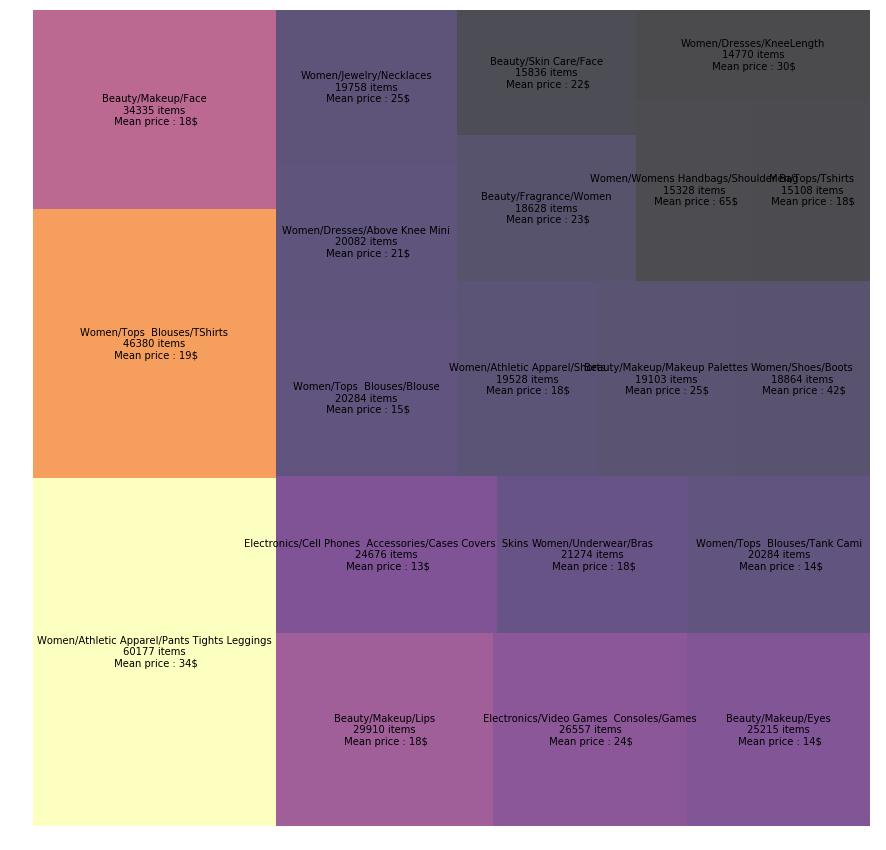

In [14]:
categories = pd.DataFrame(train.category_name.value_counts())
categories.reset_index(level = 0, inplace=True)
categories = categories.sort_values(by='category_name', ascending = False).head(20)
categories.columns =('category_name', 'size')

# Price by category
group = train.groupby(train.category_name)
mean_price = group.price.mean()
mean_price = pd.DataFrame(mean_price)
mean_price.reset_index(level = 0, inplace=True)

# Merging
categories = pd.merge(categories, mean_price, how='left', on = 'category_name')

# Colors setting
cmap = plt.cm.inferno
mini=min(categories['size'])
maxi=max(categories['size'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in categories['size']]

# Labels setting
labels = ["%s\n%d items\n Mean price : %d$" % (label) \
          for label in zip(categories['category_name'], categories['size'], categories['price'])]

# Plotting
plt.figure(figsize=(15,15))
plt.rc('font', size=10)
squarify.plot(sizes = categories['size'], label = labels, alpha = .7, color=colors)
plt.axis('off')
plt.show()

We see that the breakdown of aggregated categories can indeed be more granular. We can try to break the "category_name" field into three distinct columns for prepare the data for machine learning:

In [15]:
train['primary_cat'] = train.category_name.str.extract('([^/]+)/[^/]+/[^/]+')
train['secondary_cat'] = train.category_name.str.extract('[^/]+/([^/]+)/[^/]+')
train['tertiary_cat'] = train.category_name.str.extract('[^/]+/[^/]+/([^/]+)')

print('primary categories (head): \n',train['primary_cat'].head(5))
print('secondary categories (head): \n',train['secondary_cat'].head(5))
print('tertiary categories (head): \n',train['tertiary_cat'].head(5))

c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


primary categories (head): 
 0            Men
1    Electronics
2          Women
3           Home
4          Women
Name: primary_cat, dtype: object
secondary categories (head): 
 0                  Tops
1    Computers  Tablets
2         Tops  Blouses
3            Home Décor
4               Jewelry
Name: secondary_cat, dtype: object
tertiary categories (head): 
 0               Tshirts
1     Components  Parts
2                Blouse
3    Home Décor Accents
4             Necklaces
Name: tertiary_cat, dtype: object


In [16]:
print('unique primary categories: \n',train['primary_cat'].nunique())
print('unique secondary categories: \n',train['secondary_cat'].nunique())
print('unique tertiary categories: \n',train['tertiary_cat'].nunique())


unique primary categories: 
 10
unique secondary categories: 
 113
unique tertiary categories: 
 868


In [17]:
train['category_name']

0                                           Men/Tops/Tshirts
1           Electronics/Computers  Tablets/Components  Parts
2                                 Women/Tops  Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
5                                          Women/Other/Other
6                                    Women/Swimwear/TwoPiece
7                             Sports  Outdoors/Apparel/Girls
8                             Sports  Outdoors/Apparel/Girls
9                    Vintage  Collectibles/Collectibles/Doll
10                                        Beauty/Makeup/Face
11                                    Beauty/Fragrance/Women
12                             Women/Dresses/Above Knee Mini
13                     Other/Office supplies/School Supplies
14                                         Women/Shoes/Boots
15                                 Beauty/Makeup/Makeup Sets
16                      

There are 10 main categories (basically like aisles), 113 secondary categories (aisle contents), 870 tertiary categories, aisle category details.

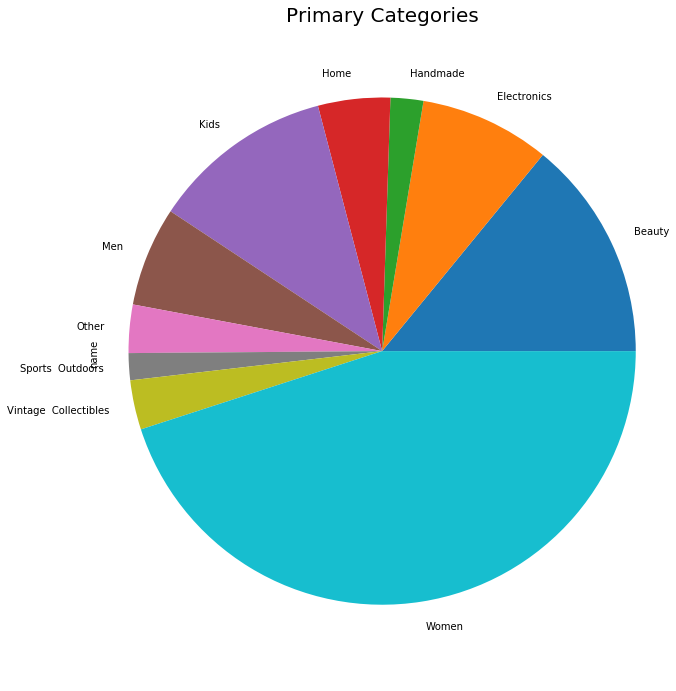

In [18]:
plt.figure(figsize = (10,12))
train.name.groupby(train.primary_cat).count().plot(kind = 'pie')
plt.title ('Primary Categories', fontsize = 20)
plt.axis('equal')
plt.show()

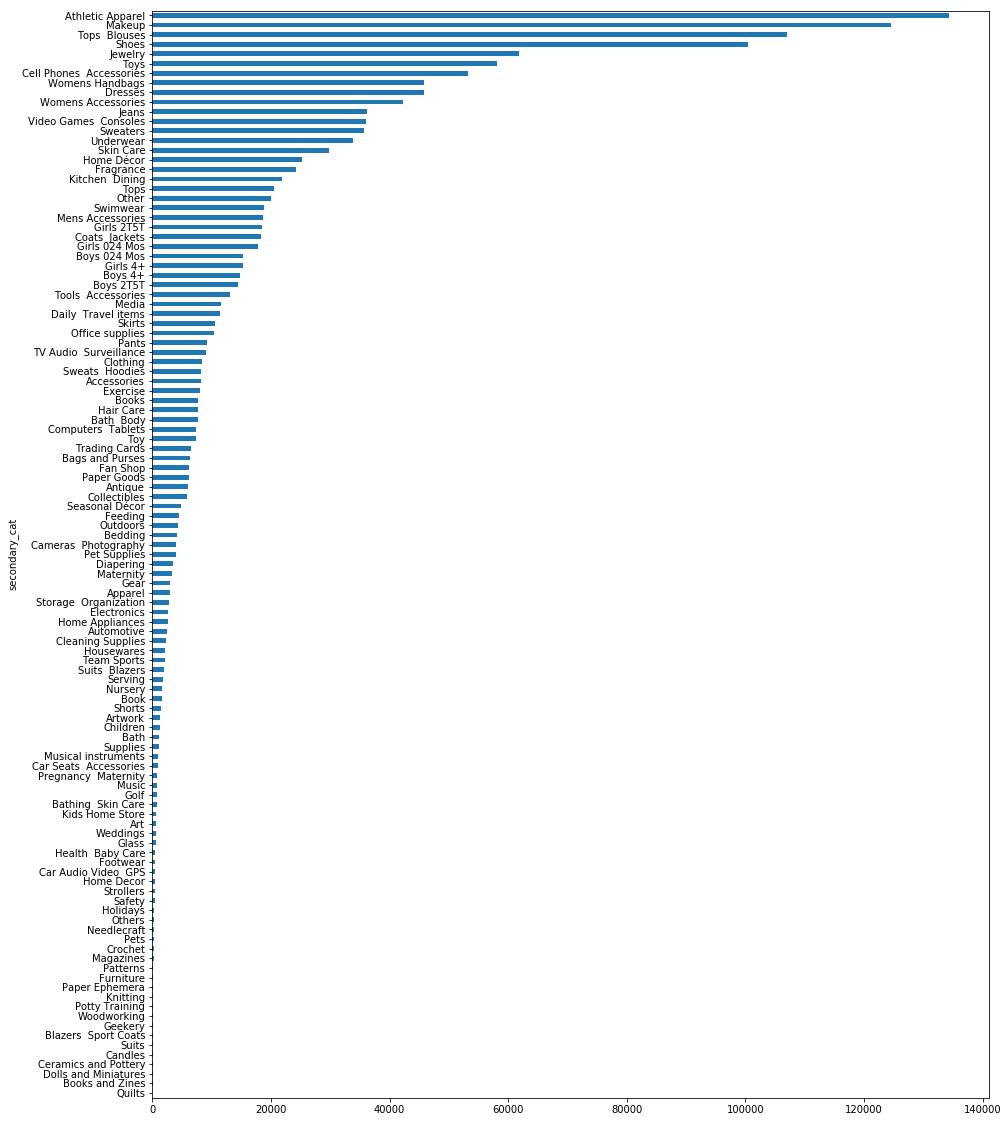

In [19]:
#Secondary Category Breakout: Count
plt.figure(figsize=(15,20))
train.name.groupby(train.secondary_cat).count().sort_values(ascending=True).plot(kind = 'barh')
plt.show()

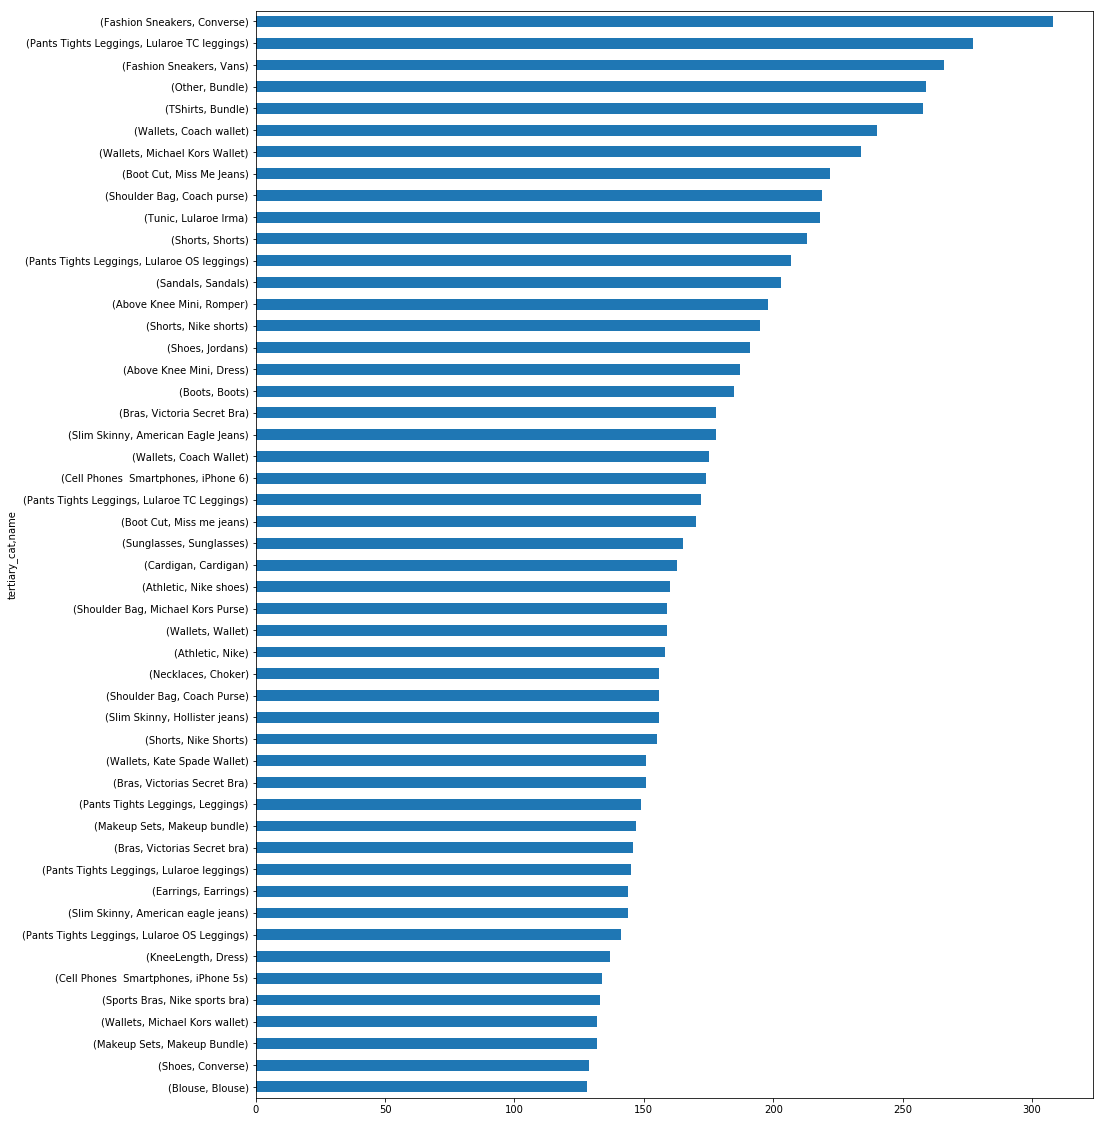

In [20]:
#Tertiary Category Breakout: Count
plt.figure(figsize=(15,20))
train.name.groupby(train.tertiary_cat).value_counts().nlargest(50).sort_values(ascending=True).plot(kind = 'barh')
plt.show()

It may be beneficial to keep the category names separate for the sake of granularity when determining price.

## III. Brand Names

In [21]:
train['brand_name'] = train.brand_name.replace(to_replace='nan', value='no brand')
train.head()
train.brand_name.value_counts()

PINK                   54088
Nike                   54043
Victoria's Secret      48036
LuLaRoe                31024
Apple                  17322
FOREVER 21             15186
Nintendo               15007
Lululemon              14558
Michael Kors           13928
American Eagle         13254
Rae Dunn               12305
Sephora                12172
Coach                  10463
Disney                 10360
Bath & Body Works      10354
Adidas                 10202
Funko                   9237
Under Armour            8461
Sony                    7994
Old Navy                7567
Hollister               6948
Carter's                6385
Urban Decay             6210
The North Face          6172
Independent             5902
Too Faced               5794
Xbox                    5709
Brandy Melville         5680
Kate Spade              5411
MAC                     5302
                       ...  
Agetec                     1
Hannspree                  1
Gearbox                    1
Boudreaux     

In [22]:
train['item_description']

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags Leather horses Retail for rm eac...
4                  Complete with certificate of authenticity
5          Banana republic bottoms Candies skirt with mat...
6          Size small but straps slightly shortened to fi...
7          You get three pairs of Sophie cheer shorts siz...
8             Girls Size small Plus green Three shorts total
9          I realized his pants are on backwards after th...
10                 025 oz Full size is 1oz for rm in Sephora
11         5 new vs pink body mists 25 oz each Fresh  Cle...
12                                        Xl great condition
13                                        No description yet
14         Authentic Suede fringe boots Great condition S...
15         Brand new Deluxe travel size products Contains...
16         2 glitter eye

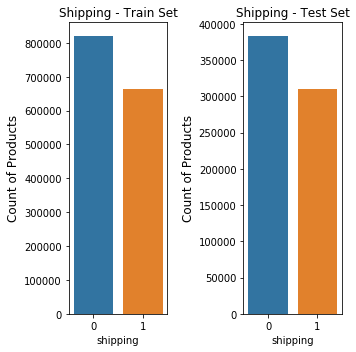

In [23]:
_ = plt.figure(figsize=(5,5))
_ = plt.subplot(1,2,1)
_ = sns.countplot(train['shipping'])
_ = plt.ylabel("Count of Products", fontsize='large')
_ = plt.title('Shipping - Train Set')


_ = plt.subplot(1,2,2)
_ = sns.countplot(test['shipping'])
_ = plt.ylabel("Count of Products", fontsize='large')
_ = plt.title('Shipping - Test Set')

plt.tight_layout()
plt.show()

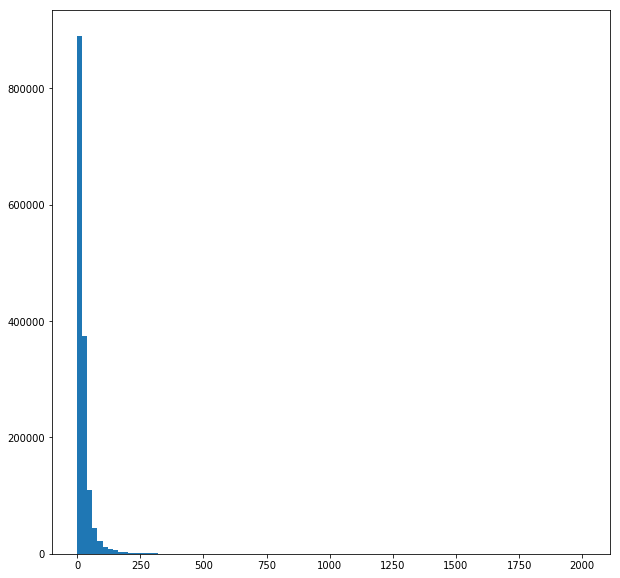

In [24]:
_ = plt.figure(figsize=(10,10))
_ = plt.hist(train['price'], bins = 100)
plt.show()